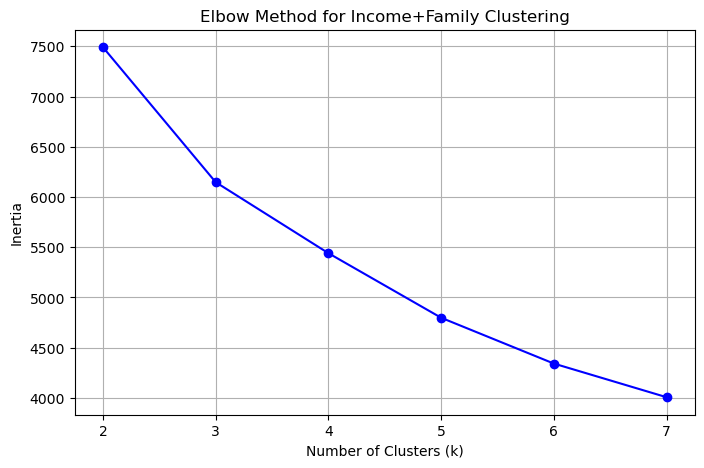

Income Cluster Summary:
                  Income  Total_Spending    Age  Education  Total_Dependents
Income_Cluster                                                              
0               31553.00          137.92  47.51       1.79              0.93
1               47100.09          304.61  61.82       2.97              1.52
2               73430.82         1188.69  57.56       2.50              0.39

Customers per cluster:
Income_Cluster
0    653
1    796
2    791
Name: count, dtype: int64

Detailed Family Impact Analysis:

Cluster 0:
  Average Income: $31553
  Average Age: 47.5
  Average Dependents: 0.9
  Average Education: 1.8
  Average Spending: $138
  % with children: 81.5%

Cluster 1:
  Average Income: $47100
  Average Age: 61.8
  Average Dependents: 1.5
  Average Education: 3.0
  Average Spending: $305
  % with children: 97.0%

Cluster 2:
  Average Income: $73431
  Average Age: 57.6
  Average Dependents: 0.4
  Average Education: 2.5
  Average Spending: $1189
  % with childr

In [6]:
# Income-Based Clustering 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Load the featured dataset
df = pd.read_csv('featured_customer_segmentation.csv')

# Select income-related features INCLUDING Total_Dependents for clustering
income_features = [
    'Income',
    'Total_Spending', 
    'Age',
    'Education',
    'Total_Dependents'  
]

# Prepare the data
X = df[income_features].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters using elbow method
inertias = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Income+Family Clustering')
plt.grid(True)
plt.show()

# Apply clustering with optimal k (let's use 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Income_Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = df.groupby('Income_Cluster')[income_features].mean().round(2)
print("Income Cluster Summary:")
print(cluster_summary)

# Count customers per cluster
print("\nCustomers per cluster:")
print(df['Income_Cluster'].value_counts().sort_index())

# Additional analysis showing family impact
print("\nDetailed Family Impact Analysis:")
for cluster in sorted(df['Income_Cluster'].unique()):
    cluster_data = df[df['Income_Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  Average Income: ${cluster_data['Income'].mean():.0f}")
    print(f"  Average Age: {cluster_data['Age'].mean():.1f}")
    print(f"  Average Dependents: {cluster_data['Total_Dependents'].mean():.1f}")
    print(f"  Average Education: {cluster_data['Education'].mean():.1f}")
    print(f"  Average Spending: ${cluster_data['Total_Spending'].mean():.0f}")
    print(f"  % with children: {(cluster_data['Total_Dependents'] > 0).mean()*100:.1f}%")

Income Cluster Means:
                      Income  Total_Spending        Age  Education  \
Income_Cluster                                                       
0               31552.996172      137.918070  47.514548   1.785605   
1               47100.089510      304.610553  61.824121   2.972362   
2               73430.823325     1188.688369  57.562579   2.501896   

                Total_Dependents  
Income_Cluster                    
0                       0.932619  
1                       1.521357  
2                       0.390645  


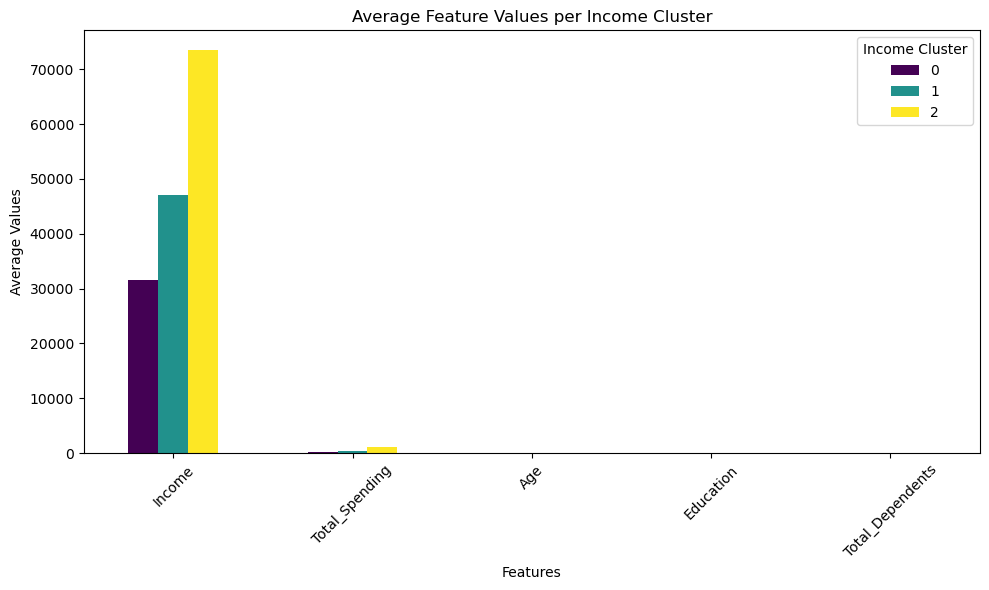

In [7]:
# Transpose the DataFrame so categories are on the x-axis
cluster_means_income = df.groupby('Income_Cluster')[income_features].mean()

print("Income Cluster Means:")
print(cluster_means_income)

# Transpose for easier plotting (features on x-axis)
cluster_means_income_T = cluster_means_income.T

# Plot grouped bar chart for income clustering
cluster_means_income_T.plot(kind='bar', figsize=(10, 6), colormap='viridis')

plt.title('Average Feature Values per Income Cluster')
plt.xlabel('Features')
plt.ylabel('Average Values')
plt.legend(title='Income Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalized Income Cluster Features (%):
                Income  Total_Spending     Age  Education
Income_Cluster                                           
0                42.97           11.60   76.85      60.07
1                64.14           25.63  100.00     100.00
2               100.00          100.00   93.11      84.17


C:\Users\DELL\AppData\Local\Temp\ipykernel_8768\984577474.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in current_values])


<Figure size 1200x800 with 0 Axes>

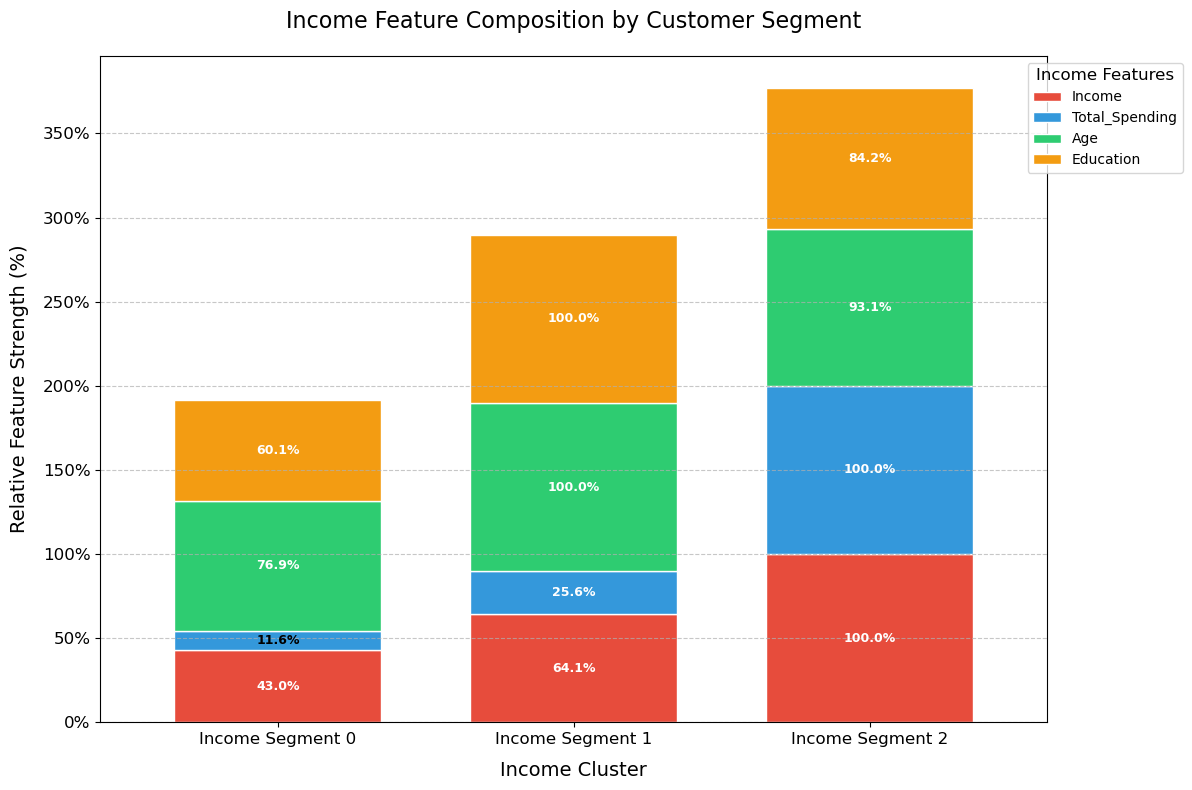

In [8]:
# Normalize income features by total per cluster for income clustering
normalized_income = df.groupby('Income_Cluster')[
    ['Income', 'Total_Spending', 'Age', 'Education']
].mean()

# Create proportional representation (normalize by max value in each feature)
# Since these features have different scales, we'll normalize each feature separately
normalized_income_scaled = normalized_income.copy()
for col in normalized_income_scaled.columns:
    max_val = normalized_income_scaled[col].max()
    normalized_income_scaled[col] = (normalized_income_scaled[col] / max_val) * 100

print("Normalized Income Cluster Features (%):")
print(normalized_income_scaled.round(2))

# Create a colorful stacked bar chart for income features
plt.figure(figsize=(12, 8))

# Use a different color palette for income features
income_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
normalized_income_scaled.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=income_colors,
    width=0.7,
    edgecolor='white'
)

# Enhance styling
plt.title('Income Feature Composition by Customer Segment', fontsize=16, pad=20)
plt.xlabel('Income Cluster', fontsize=14, labelpad=10)
plt.ylabel('Relative Feature Strength (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage signs to y-axis
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in current_values])

# Improve legend
plt.legend(
    title='Income Features',
    title_fontsize=12,
    fontsize=10,
    loc='upper right',
    bbox_to_anchor=(1.15, 1)
)

# Add value labels on the stacked bars
for i, cluster in enumerate(normalized_income_scaled.index):
    cumulative = 0
    for j, col in enumerate(normalized_income_scaled.columns):
        value = normalized_income_scaled.loc[cluster, col]
        if value > 10:  # Only show labels for segments > 10%
            plt.text(
                i,
                cumulative + value / 2,
                f"{value:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='white' if value > 20 else 'black'
            )
        cumulative += value

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rename x-axis labels to more meaningful names
plt.gca().set_xticklabels([
    'Income Segment 0',
    'Income Segment 1', 
    'Income Segment 2'
])

plt.tight_layout()
plt.show()



Income Cluster Means:
                      Income  Total_Spending        Age  Education  \
Income_Cluster                                                       
0               31552.996172      137.918070  47.514548   1.785605   
1               47100.089510      304.610553  61.824121   2.972362   
2               73430.823325     1188.688369  57.562579   2.501896   

                Total_Dependents  
Income_Cluster                    
0                       0.932619  
1                       1.521357  
2                       0.390645  


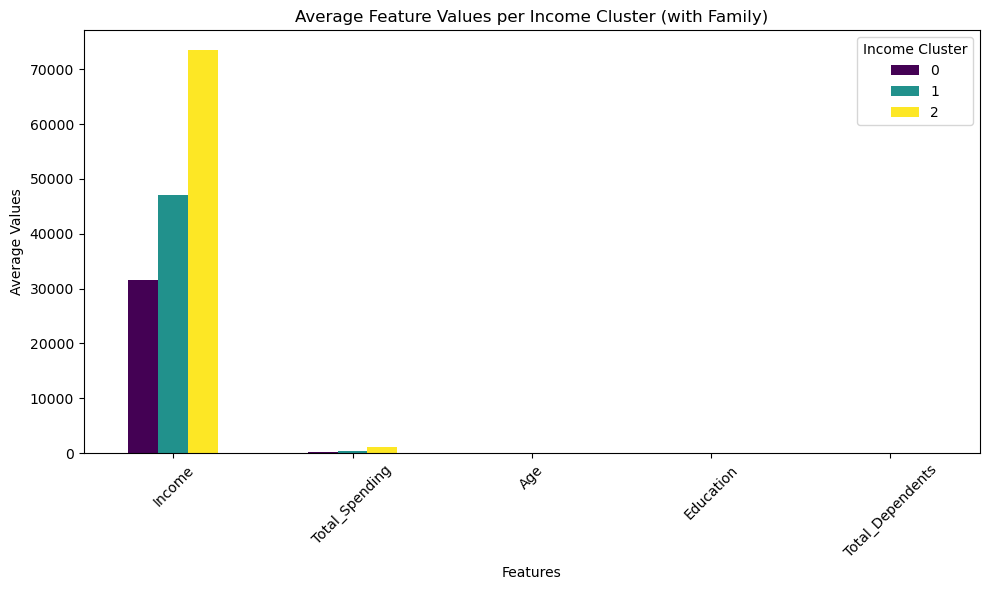

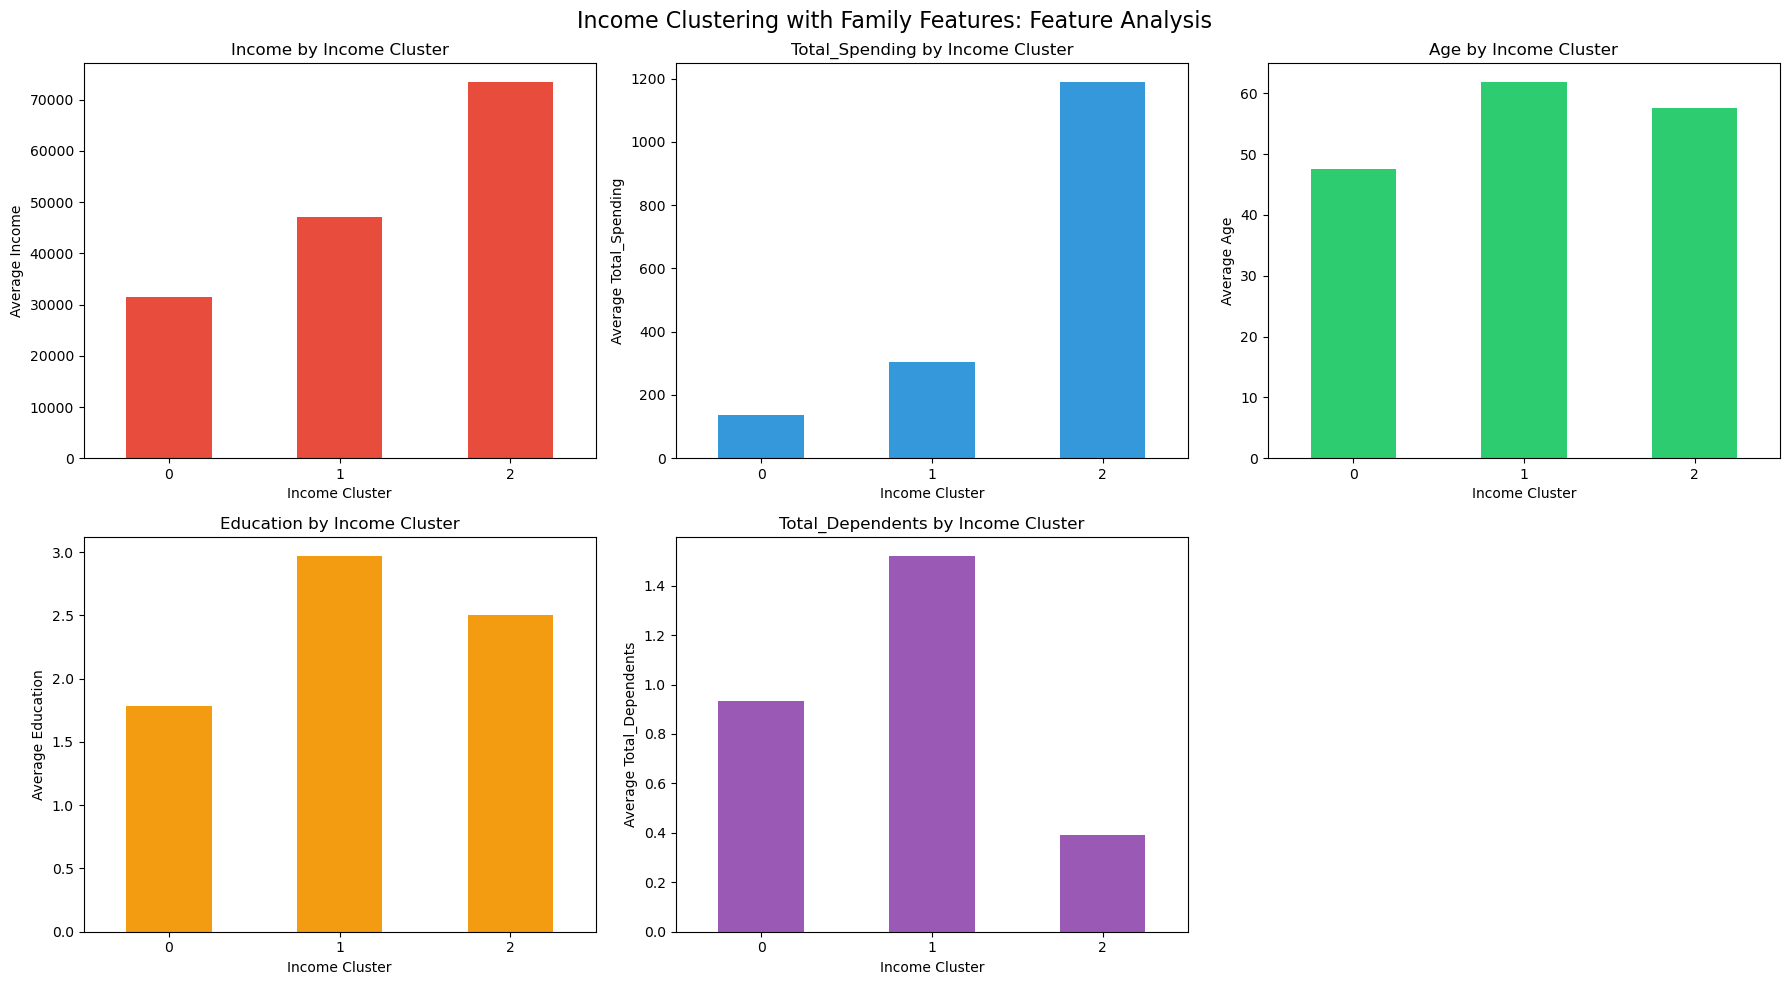

In [9]:
# Transpose the DataFrame so categories are on the x-axis for income clustering
cluster_means_income = df.groupby('Income_Cluster')[income_features].mean()

print("Income Cluster Means:")
print(cluster_means_income)

# Transpose for easier plotting (features on x-axis)
cluster_means_income_T = cluster_means_income.T

# Plot grouped bar chart for income clustering
cluster_means_income_T.plot(kind='bar', figsize=(10, 6), colormap='viridis')

plt.title('Average Feature Values per Income Cluster (with Family)')
plt.xlabel('Features')
plt.ylabel('Average Values')
plt.legend(title='Income Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Alternative: Side-by-side comparison with Total_Dependents highlighted
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Income Clustering with Family Features: Feature Analysis', fontsize=16)

features = ['Income', 'Total_Spending', 'Age', 'Education', 'Total_Dependents']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for idx, feature in enumerate(features):
    if idx < 5:  # We have 5 features
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        cluster_means_income[feature].plot(kind='bar', ax=ax, color=colors[idx])
        ax.set_title(f'{feature} by Income Cluster')
        ax.set_xlabel('Income Cluster')
        ax.set_ylabel(f'Average {feature}')
        ax.tick_params(axis='x', rotation=0)

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()